# Copyright

<PRE>
Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2018 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu)
</PRE>

# Konvolúciós neurális hálózatok - alapok
Jelen notebookban a konvolúciós hálók használatának alapjaival ismerkedünk meg. Az itteni példa publikusan elérhető kép adatbázisok két dimenziós konvolúciós hálózattal történő feldolgozásáról fog szólni. Fontos megjegyezni, hogy ahogy a konvolúciós hálók felhasználása ma már sokkal bővebb, mint pusztán képfelismerés, szinte bármilyen tématerületen sikeresen alkalmazzák (pl. beszéd, hang, idősorok, játék botok, stb.).

Az első példánkban Yann LeCunn professzor MNIST kézzel írott szám adatbázisát fogjuk betanítani a hálóval. Az adatbázis elérhető publikusan: http://yann.lecun.com/exdb/mnist/
Illetve szinte mindegyik nagyobb deep learning frameworkben be lehet tölteni parancssorból. A mostani példában a Keras-t fogjuk használni így most ennek a beépített függvényével töltjük be az adatokat:

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Adatok előkészítése:

In [0]:
x_train = x_train.reshape(-1,28*28)
x_test = x_test.reshape(-1,28*28)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train = x_train / 255
x_test = x_test / 255

In [0]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [0]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [0]:
batch_size=128

# Egyszerű regressziós modell

A tanítás előtt kapcsoljuk be a GPU-t Colab alatt (Runtime/Change runtime type). Ezután létrehozunk egy egyszerű regressziós modellt softmax aktivációs függvénnyel és betanítjuk batch_size batch mérettel:

In [6]:
import tensorflow as tf
sess = tf.Session()
# bemenet és kimenet definiálása
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
# a súlymátrixa és bias vektor definiálása
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
# inicializálás
sess.run(tf.global_variables_initializer())
# a regresszió létrehozása
y = tf.nn.softmax(tf.matmul(x,W) + b)
# a költségfüggvény megadása
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# optimációs algoritmus megadása 
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
# tanítás 1000 epoch, batch_size batch méret
batch_counter=0
for i in range(1000):
    train_step.run(session=sess, feed_dict={x: x_train[batch_counter*batch_size:(batch_counter+1)*batch_size], y_: y_train[batch_counter*batch_size:(batch_counter+1)*batch_size]})
    batch_counter=batch_counter+1
    if (batch_counter*batch_size > len(x_train)):
        batch_counter=0

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Ha megvan a betanított modellünk, akkor utána megnézzük, hogy hogyan teljesít a teszt képekre (amik nem voltak benne a tanító adatbázisban:

In [7]:
# ez megadja, hogy hányszor találtuk el 
# (az argmax megadja a legnagyobb értékhez tartozó indexet a második paraméter dimenziójában)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
# ez pedig kitszámolja ezek átlagát
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# most pedig lefuttatjuk a teszt képekre
print(accuracy.eval(session=sess, feed_dict={x: x_test, y_: y_test}))

0.9139


Tehát ez a modell kb. 91%-t találta el a betanított numerikus értékeknek.

# Konvolúciós neurális hálózat
Következő lépésként konvolúciós neurális hálózatokkal tanítjuk be a számokat és megnézzük, hogy így milyen pontosságot tudunk elérni. Először definiáljuk a hálózatunkat:

In [0]:
# változók inicializálása. 
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1, name="weights")
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# konvolúciós és max-pool rétegek inicializálása
def conv2d(x, W, name):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# háló architektúrájának összerakása

# első konvolúciós réteg 1@28x28,f:5x5@32,z:2x2
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, "h_conv1") + b_conv1) # 28x28 ---> 28x28
h_pool1 = max_pool_2x2(h_conv1) # 28x28 ---> 14x14

# második konvolúciós réteg 32@14x14,f:5x5@64,z:2x2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, "h_conv2") + b_conv2) # 14x14 ---> 14x14
h_pool2 = max_pool_2x2(h_conv2) # 14x14 ---> 7x7

# fully connected rétegek
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout a kimeneti réteg előtt
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
                   
# kimeneti softmax réteg
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Ezután következik a tanítás ADAM optimizációs algoritmussal. Figyeljük meg, hogy kiértékeléskor a dropout-nak 1-es értéket adunk, tanítás során pedig 0.5-öt.

In [9]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
batch_counter=0
for i in range(1000):
    if i%100 == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={x: x_train[batch_counter*batch_size:(batch_counter+1)*batch_size], y_: y_train[batch_counter*batch_size:(batch_counter+1)*batch_size], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(session=sess, feed_dict={x: x_train[batch_counter*batch_size:(batch_counter+1)*batch_size], y_: y_train[batch_counter*batch_size:(batch_counter+1)*batch_size], keep_prob: 0.5})
    batch_counter=batch_counter+1
    if (batch_counter*batch_size > len(x_train)):
        batch_counter=0    

print("test accuracy %g" % accuracy.eval(session=sess, feed_dict={x: x_test, y_: y_test, keep_prob: 1.0}))

step 0, training accuracy 0.101562
step 100, training accuracy 0.929688
step 200, training accuracy 0.9375
step 300, training accuracy 0.953125
step 400, training accuracy 0.921875
step 500, training accuracy 0.945312
step 600, training accuracy 0.960938
step 700, training accuracy 0.960938
step 800, training accuracy 0.953125
step 900, training accuracy 0.960938
test accuracy 0.9728


# A konvolúciós hálózat vizsgálata

## Metrikák, konfúziós (tévesztési) mátrix
Nézzük először, hogy hogyan tudjuk kiszámolni az osztályozáshoz tartozó legfontosabb metrikákat és hogyan tudjuk megjeleníteni a konfúziós mátrixot:

In [10]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, confusion_matrix
# először is nyerjük ki a predikciókat (valószínüség és hozzá tartozó pontosságot)
test_accuracy, y_pred = sess.run([accuracy, y_conv], feed_dict={x: x_test, y_: y_test, keep_prob: 1.0})
y_pred=np.argmax(y_pred,1)

print("test accuracy: %g" %(test_accuracy))
y_true = np.argmax(y_test,1)
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))
print("\nKonfúziós mátrix: ")
print(confusion_matrix(y_true, y_pred))

test accuracy: 0.9728
Precision 0.9728665905229461
Recall 0.9726049978907294
f1_score 0.9726925489900173

Konfúziós mátrix: 
[[ 967    1    0    0    0    0    5    2    4    1]
 [   0 1125    3    1    0    1    3    0    2    0]
 [   4    1 1003    4    1    1    0    8    9    1]
 [   0    0    6  983    0    7    0    6    6    2]
 [   1    1    5    0  944    0    5    2    4   20]
 [   2    0    0   12    0  867    3    2    5    1]
 [   7    3    1    1    2    6  934    0    4    0]
 [   0    4   20    1    0    0    0  987    3   13]
 [   2    1    3    8    0    2    1    5  947    5]
 [   2    5    1    8    3    5    1    6    7  971]]


Fontos felhívni a figyelmet a precision, recall és f1 esetén az "avarage" paraméterre. Mivel ezek a metrikák alapvetően két osztályt vesznek figyelembe, ezért több lehetőségünk van több osztálynál az értékek figyelembe vételére. Ennek talán legegyszerűbb módja a "macro", amikor minden osztálynál kiszámolt érték átlagát veszi. Ha "micro"-ra állítjuk, akkor összegzi az összes osztály esetén a TP, TN, FN, FP értékeket és ezekkel számol. "weighted" esetben pedig azt is figyelembe veszi, hogy melyik osztályban mennyi minta van, és amelyikbe sok, azt nagyobb súllyal veszi figyelembe. 

## Réteg aktivációk 
Az eddigiek eredményeképp kaptunk egy betanult hálót, ami a fenti valószínűséggel képes 0-9 közötti számjegyek felismerésére. Most vizsgáljuk meg, hogy az egyes konvolúciós rétegekben egy adott bemenetre milyen értékek jelennek meg. Ehhez csupán annyit kell tennünk, hogy a bemenetet ráadjuk a hálóra, és rétegenként és "szeletenként" megjelenítjük az egyes neuronok kimenetét. Itt elsősorban azt szoktuk vizsgálni, hogy különböző bemenetekre kapunk-e a bemenethez tartozó értelmes kimenetet. Ha több kép esetén csupa nulla (fekete) aktivációkat kapunk, akkor az azt jelenti, hogy ReLU aktivációs függvények negatív tartományában van a háló - valamit elrontottunk tanításnál. Ha az első rétegben van ez a jelenség, akkor azt sokszor a túl magas tanulási ráta (learning rate) vagy rosszul konvergáló optimizációs algoritmus okozza. 

Az aktivációk vizsgálatához először töltsünk be egy tetszőleges teszt képet az MNIST adatbázisból és jelenítsük meg:

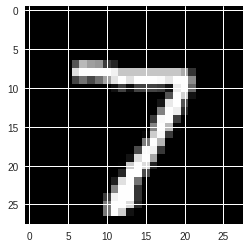

In [11]:
import numpy as np 
import math
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt

testInputToShow = x_test[0]
plt.imshow(np.reshape(testInputToShow,[28,28]), interpolation="nearest", cmap="gray")

 Ezt követően készítsünk egy függvényt egy adott réteghez tartozó összes "szelet" kimenetének megjelenítésére:

In [0]:
def showConvActivationAtFilterx(layer,inputdata):
    # ez jelent egy forward propagation-t az adott rétegig, amit paraméterben adunk át
    units = layer.eval(session=sess,feed_dict={x:np.reshape(inputdata,[1,784],order='F'),keep_prob:1.0})
    # az adott réteghez tartozó tömbnek a negyedik (3-as indexű) dimenzija tartalmazza az adott konvolúciós "szeletek" kimenetét
    filters = units.shape[3]
    # létrehozunk egy új ábrát
    plt.figure(1, figsize=(32,32))
    # majd az egyes kimeneteket külön ábrázoljuk
    for i in range(0,filters):
        plt.subplot(math.ceil(filters/6)+1,6,i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="none", cmap="gray")


És ez után jelenítsük meg az egyes konvolúciós rétegeket, ha a testInputToShow bemenetet adjuk a hálónak:

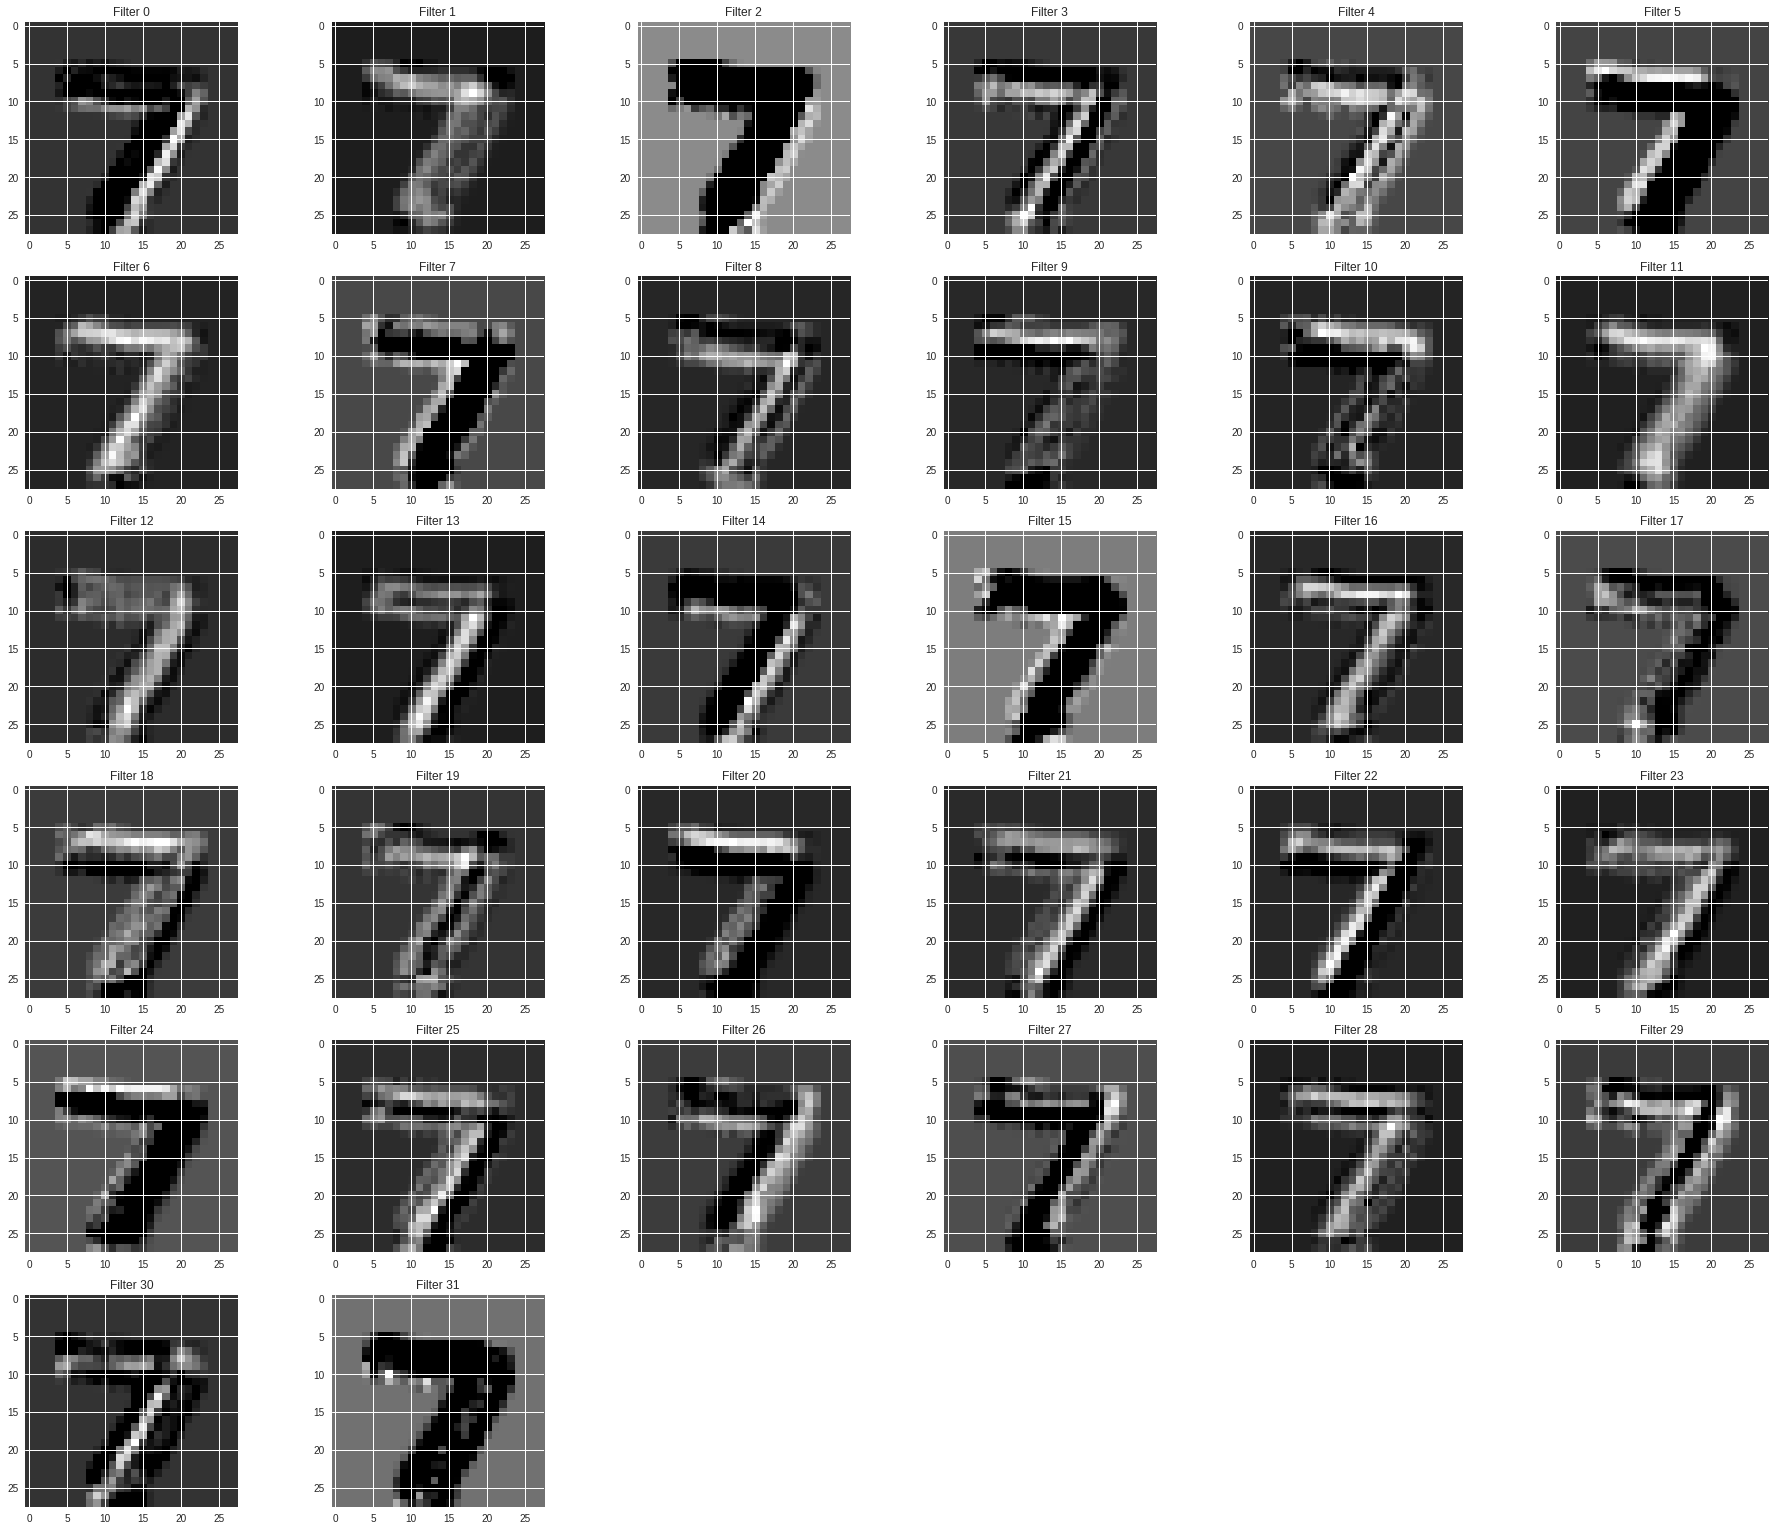

In [13]:
showConvActivationAtFilterx(h_conv1, testInputToShow) # az első konvolúciós réteg kimeneteinek megjelenítése

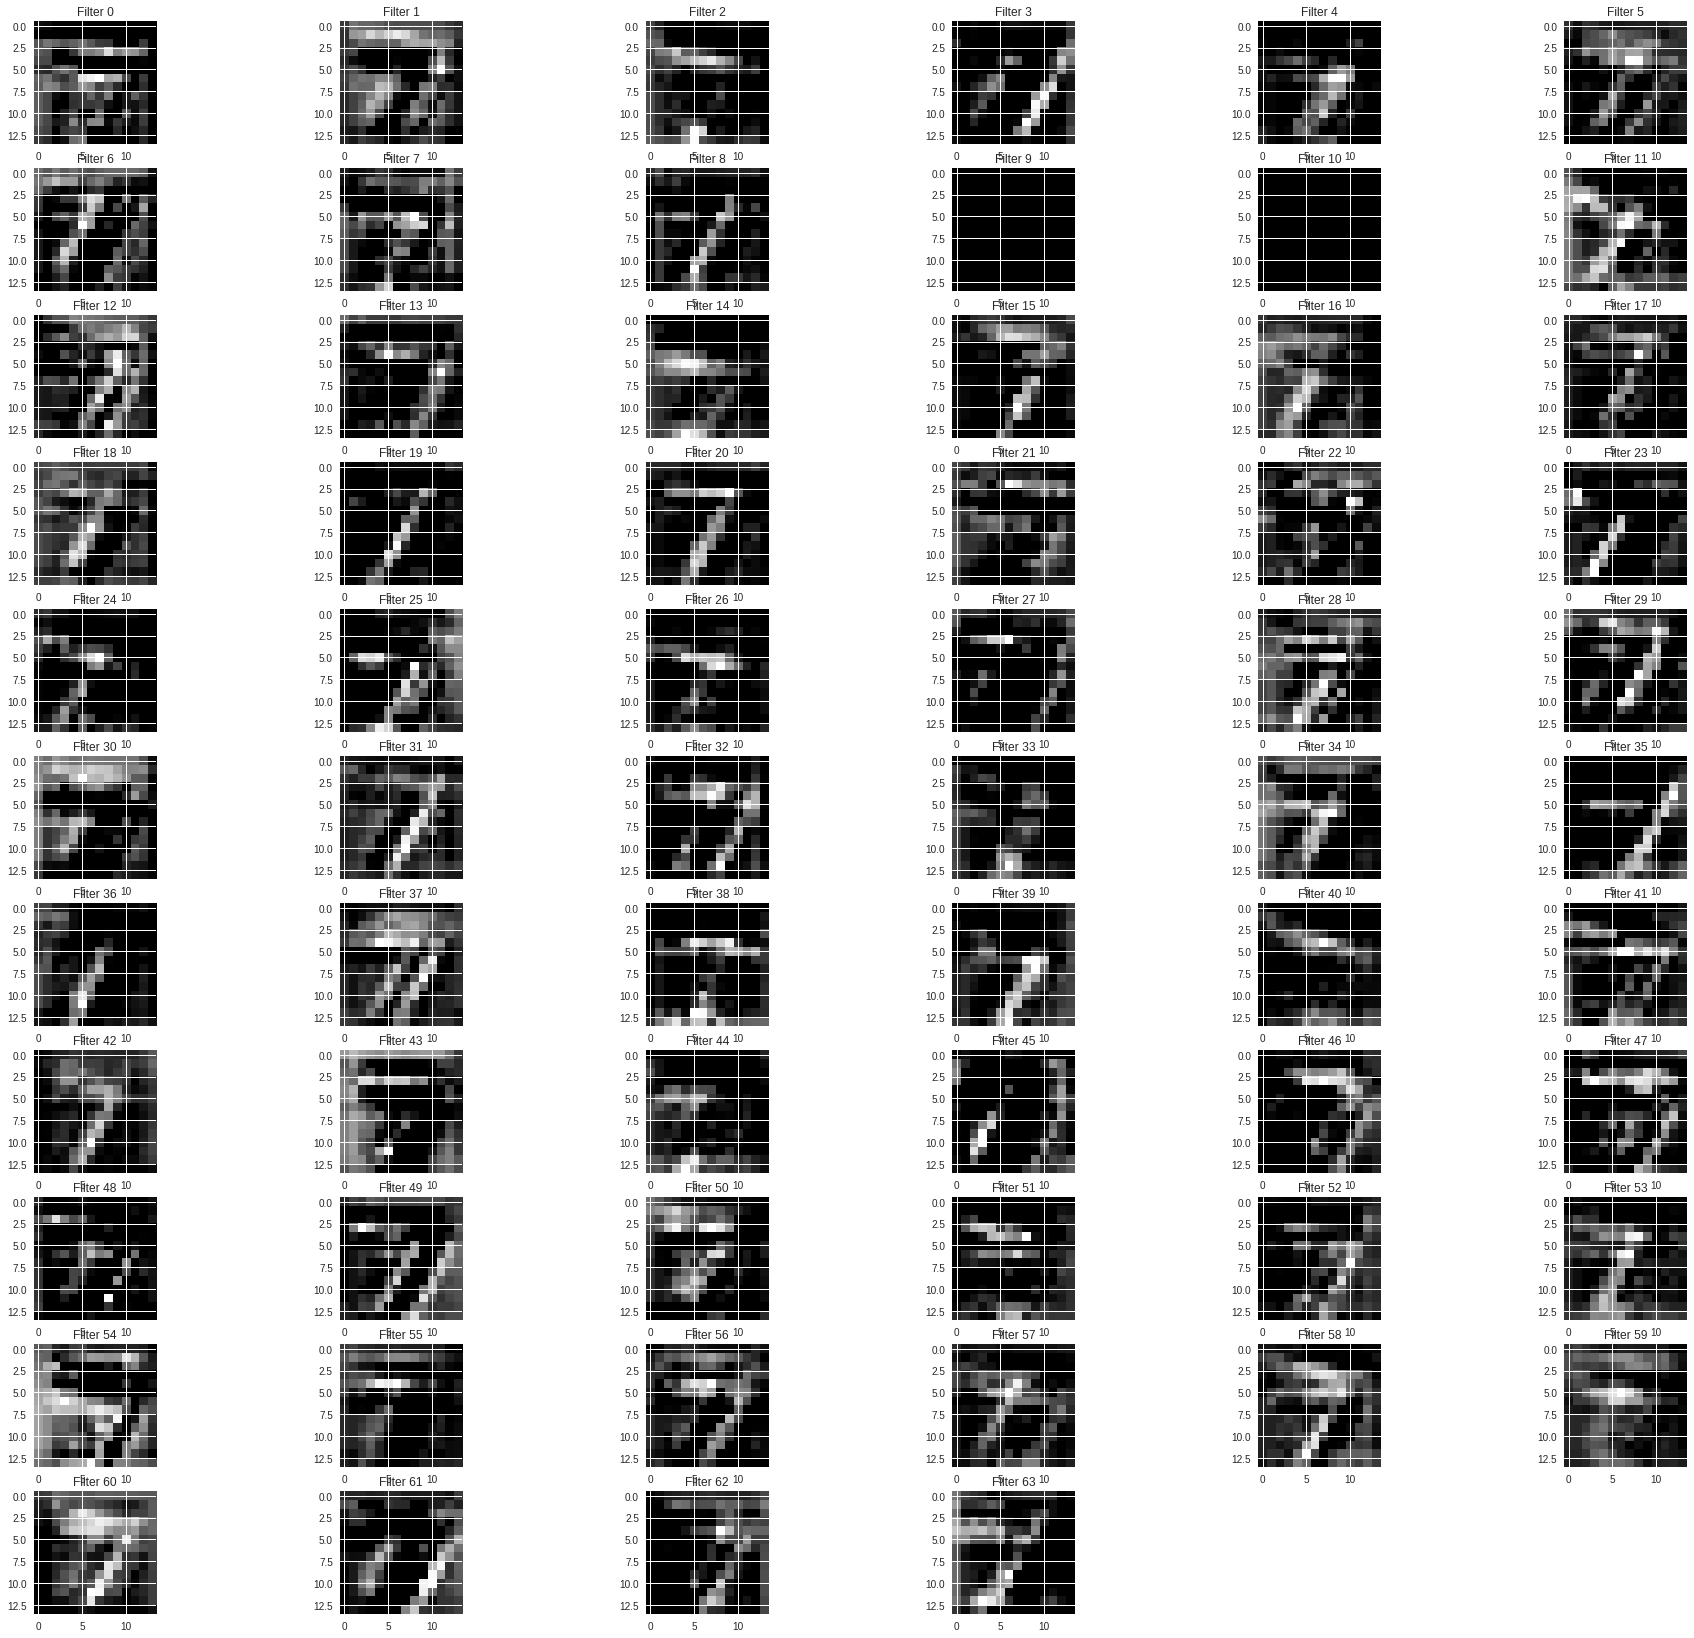

In [14]:
showConvActivationAtFilterx(h_conv2, testInputToShow) # a második konvolúciós réteg kimeneteinek megjelenítése

## Konvolúciós szűrők
A konvolúciós hálónk vizsgálatának másik lehetőség, hogy az adott konvolúciós réteghez tartozó szűrőnek a súlyait jelenítjük meg. Ezt a korábban ismertetett módszerhez hasonlóan jelenítjük meg, most azonban az adott réteg adott síkjához tartozó súlymátrixit rajzoljuk ki.

In [0]:
def showConvFilterx(w):
    # az adott réteghez tartozó súlyok lekérdezése
    weights=w.eval(session=sess)
    # a szűrők száma a súlymátrix negyedik (3-as indexű) dimenziója
    no_filters=weights.shape[3]
    plt.figure(1, figsize=(32,32))
    for i in range(0,no_filters):
        plt.subplot(math.ceil(no_filters/6)+1,6,i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(weights[:,:,0,i], interpolation="none", cmap="gray")    

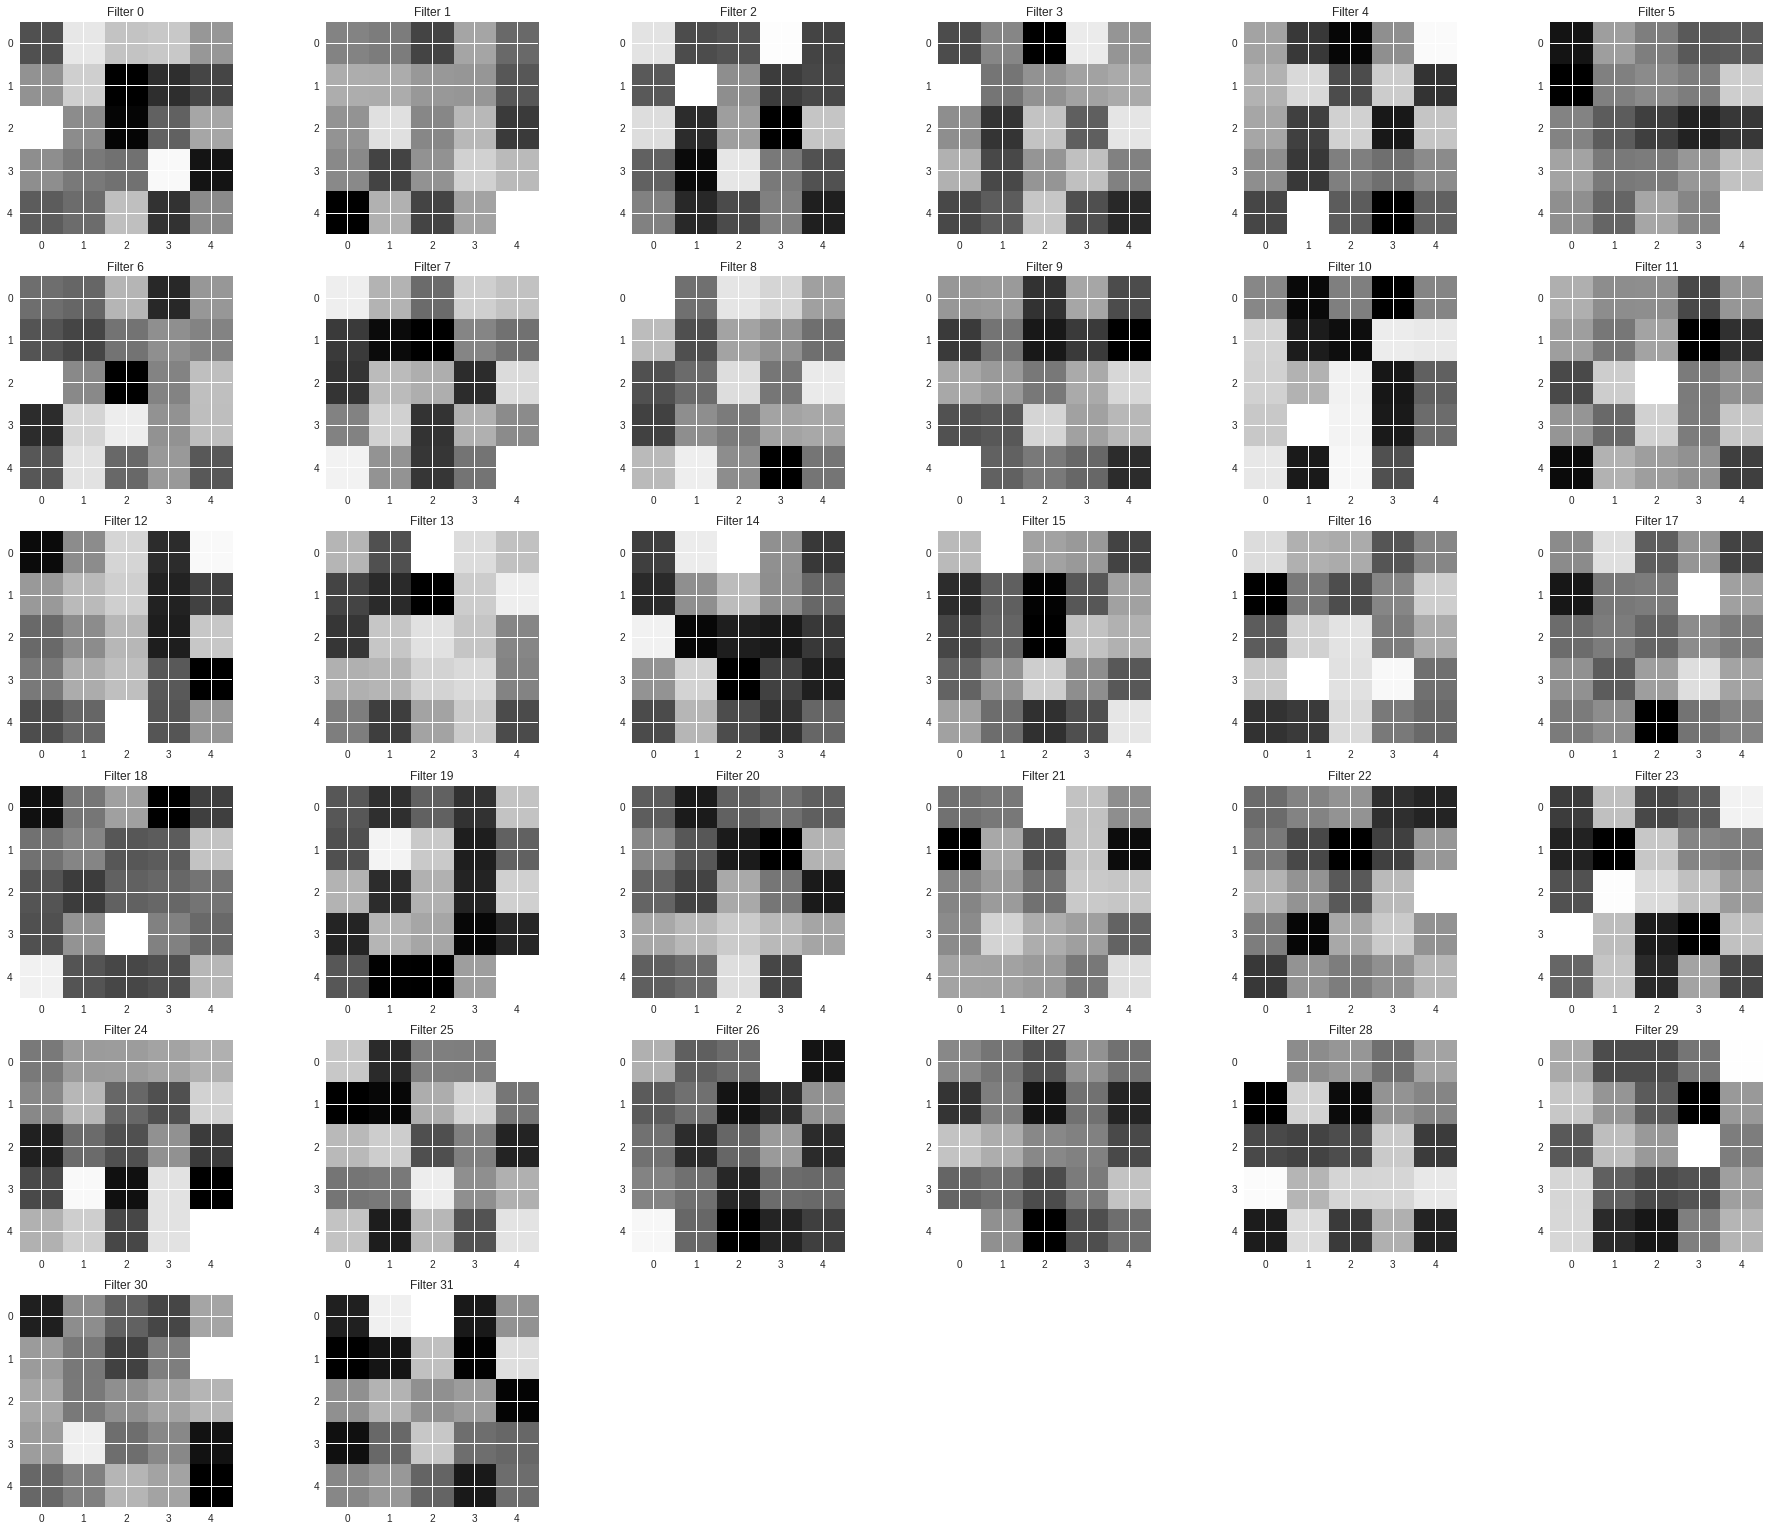

In [16]:
showConvFilterx(W_conv1) # első konvolúció réteghez tartozó szűrők súlyainak megjelenítése

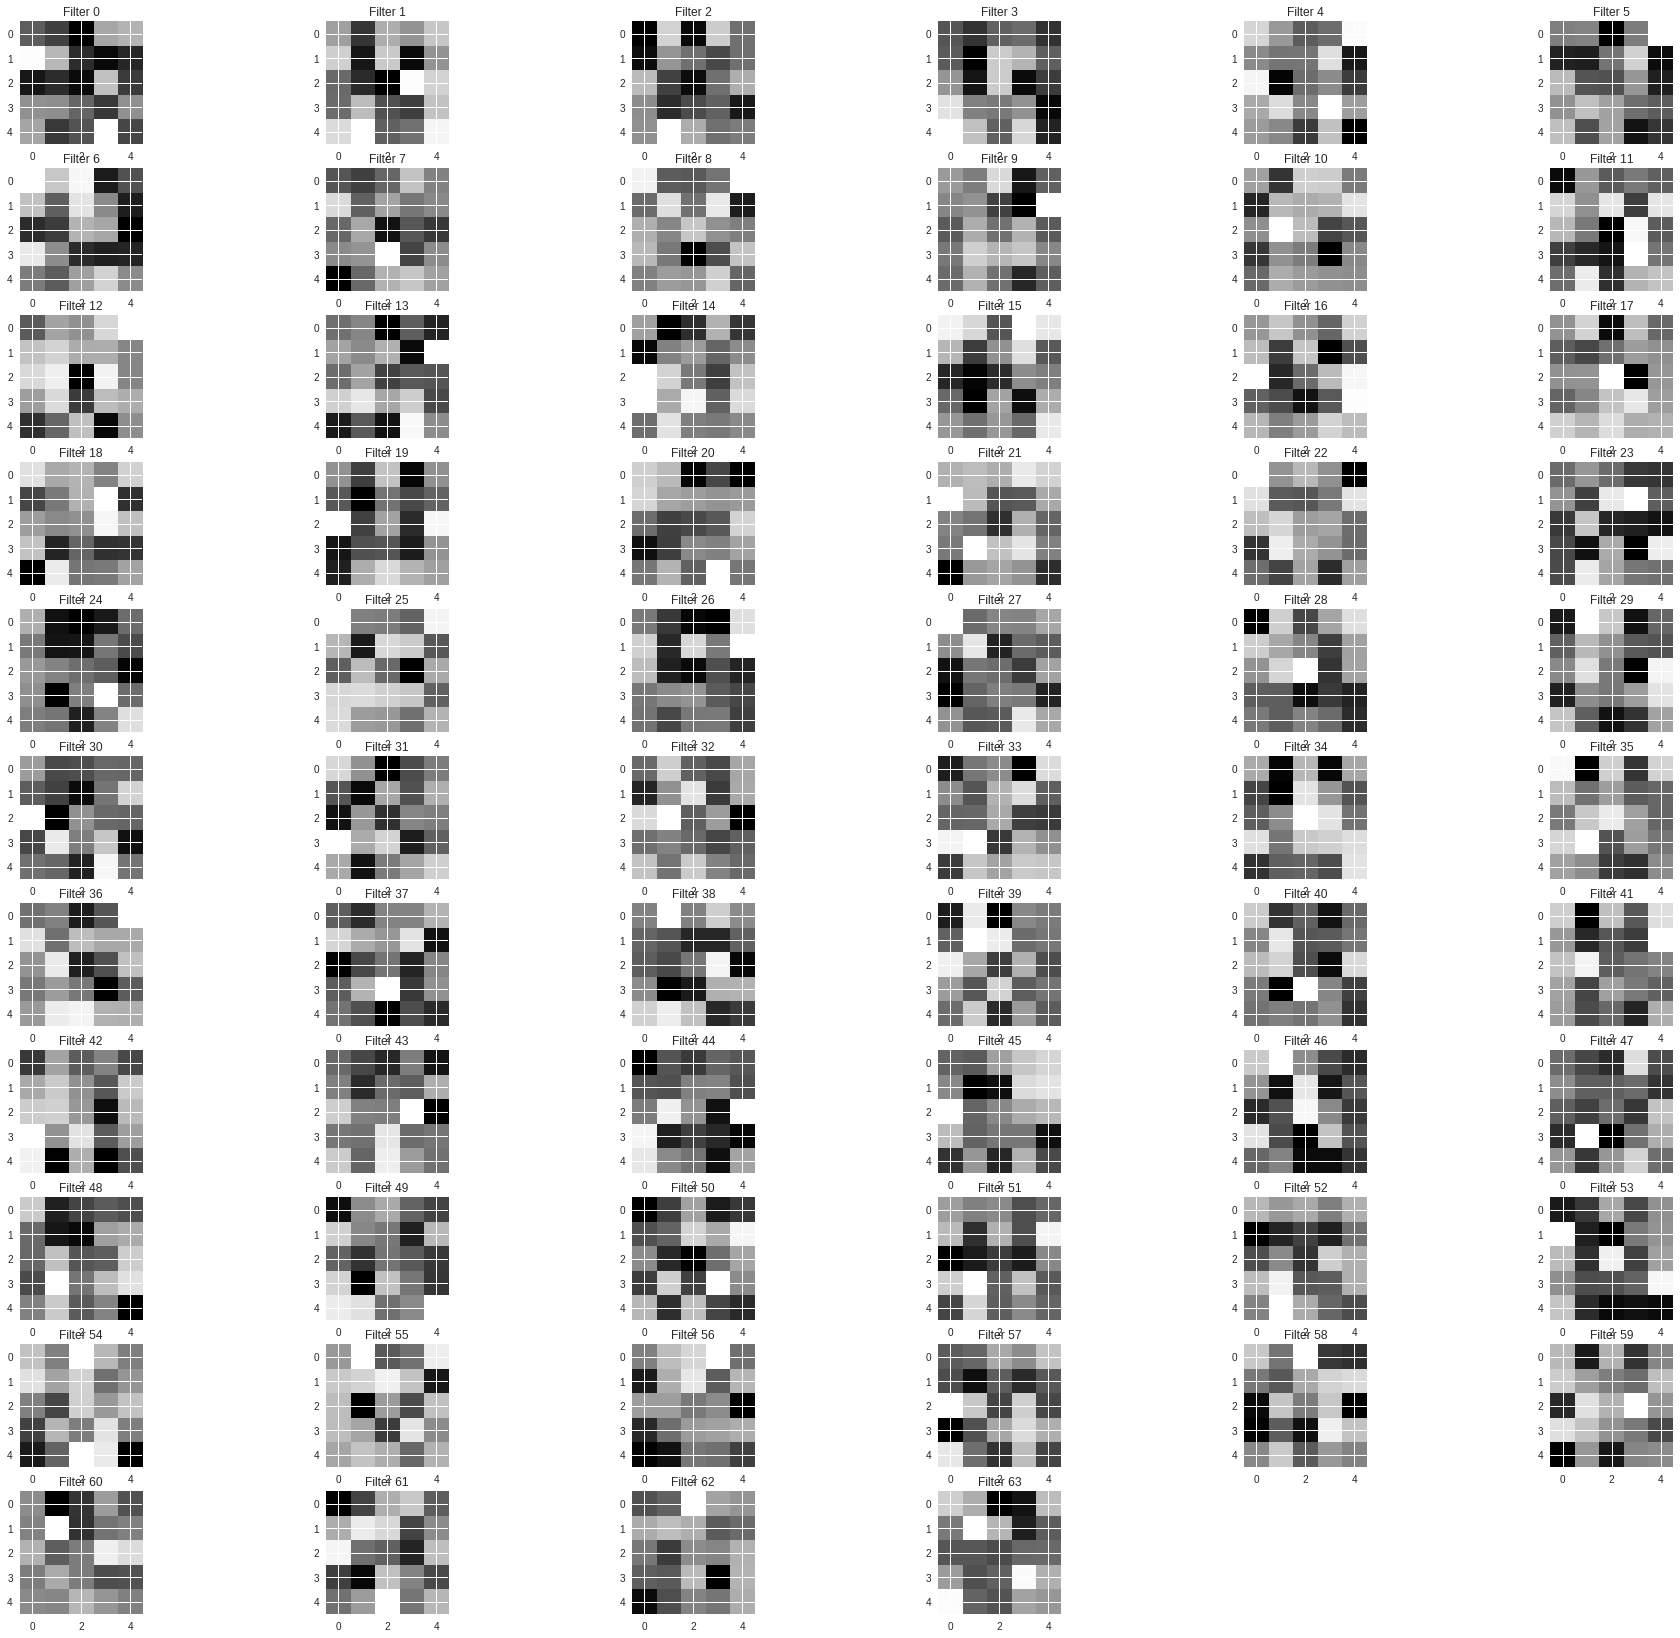

In [17]:
showConvFilterx(W_conv2) # második konvolúció réteghez tartozó szűrők súlyainak megjelenítése